In [74]:
import urllib.request
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
label_rates = [-20+0.5*x for x in range(81)]
def fit_rates(n):
    if n < label_rates[0]:
        return label_rates[0]
    if n > label_rates[-1]:
        return label_rates[-1]
    for i in range(1,len(label_rates)-1):
        if n<label_rates[i]+0.5 and n>label_rates[i]-0.5:
            return label_rates[i]
        # if n < 0 and n>=label_rates[i-1] and n < label_rates[i]:
        #     return label_rates[i]
        # if n > 0 and n>label_rates[i] and n <= label_rates[i+1]:
        #     return label_rates[i]
    return 0
def basic_info(**arg):
    url = "http://chart.finance.yahoo.com/table.csv?s={scode}&g=d&ignore=.csv"
    f = urllib.request.urlopen(url.format(**arg))
    res = pd.read_csv(f)
    res = res.iloc[::-1].reset_index(drop=True)
    return res
def set_rates(b_info,res):
    b_info['VarRate'] = pd.Series(100*(b_info['Close'].values - b_info['Open'].values) / b_info['Open'].values)
    b_info['HiRate'] = pd.Series(100*(b_info['High'].values - b_info['Open'].values) / b_info['Open'].values)
    b_info['LoRate'] = pd.Series(100*(b_info['Low'].values - b_info['Open'].values) / b_info['Open'].values)
    res['HiRate_l']= b_info['HiRate']
    res['LoRate_l']= b_info['LoRate']
    res['VarRate_l']= b_info['VarRate']
    return None
def sma(period , b_info , res):#simple moving avg
    sma_ = b_info['Close'].rolling(window=period,center=False).mean()
    b_info['sma'+str(period)] = sma_
    res['sma_r'+str(period)] = pd.Series(b_info['Close'].values/sma_.values)
def vma(period , b_info , res):#simple moving agv for volume
    def fit_vol_ratio(n):
        try:
            return log(n,2)
        except:
            return 0.0
    avg_ = b_info['Volume'].rolling(window=period,center=False).mean()
    b_info['vma'+str(period)] = avg_
    res['vma_r'+str(period)] = pd.Series(b_info['Volume'].values/avg_.values).apply(fit_vol_ratio)
def wr(period , b_info , res):#williams %r index
    hi = b_info['High']
    lo = b_info['Low']
    rh = hi.rolling(window=period,center = False).max()
    rl = lo.rolling(window=period,center = False).min()
    b_info['w%r'+str(period)] = (rh.values - b_info['Close'].values)/(rh.values - rl.values)
    res['w%r_l'+str(period)] = b_info['w%r'+str(period)]
def boll(period , b_info , res):#bollinger bands
    std = b_info['Close'].rolling(window=period,center = False).std()
    mid = b_info['Close'].rolling(window=period,center = False).mean()
    upper = mid + 2*std
    lower = mid - 2*std
    b_info['boll_u'+str(period)] = upper
    b_info['boll_l'+str(period)] = lower
    b_info['%b'+str(period)] = (b_info['Close'].values - lower.values)/(upper.values-lower.values)
    b_info['bw'+str(period)] = (upper.values - lower.values)/mid.values
    res['%b_r'+str(period)] = b_info['%b'+str(period)]
    res['bw_r'+str(period)] = b_info['bw'+str(period)]
def sto(kperiod,dperiod,b_info,res): # stochastic oscillation index
    rl = b_info['Low'].rolling(window=kperiod,center=False).min()
    rh = b_info['High'].rolling(window=kperiod,center=False).max()
    k = (b_info['Close'].values - rl)/(rh - rl)
    d = k.rolling(window=dperiod,center=False).mean()
    b_info['%k'+str(kperiod)] = k
    res['%k_r'+str(kperiod)] = k
    b_info['%d{0}_{1}'.format(kperiod,dperiod)] = d
    res['%d_r{0}_{1}'.format(kperiod,dperiod)] = d
def cci(period , b_info , res):
    tp = pd.Series((b_info['High'].values+b_info['Low'].values+b_info['Close'].values)/3)
    ma = tp.rolling(window = period,center = False).mean()
    md = tp.rolling(window = period,center = False).std()
    cci_ = (tp-ma)/(0.015*md)
    b_info['cci'+str(period)] = cci_
    res['cci_l'+str(period)] = cci_
def index(b_info,res,*arg):
    for ind in arg:
        w = re.match(r'([a-zA-Z]+)([0-9]+)(_[0-9]+)?',ind)
        if not w.group(3):
            eval(w.group(1))(int(w.group(2)),b_info,res)
        else:
            eval(w.group(1))(int(w.group(2)),int(w.group(3)[1:]),b_info,res)
    af = pd.concat([b_info,res],axis = 1)
    af = af.dropna()
    res = af[res.keys()]
    b_info = af[b_info.keys()]

In [70]:
from scipy.cluster import hierarchy
import scipy
import re
class Stock_Pool:
    def __init__(self,**args):
        try:
            global rates_labels
            rates_labels = args['rates_labels']
        except:
            pass
        try:
            self.scodes = args['scodes']
        except:
            raise Exception("No scode")
        try:
            self.indexes = args['indexes']
        except:
            self.indexes = []
        try:
            self.params = args['params']+['diff_mean']
        except:
            self.params = ['diff_mean']
        try:
            self.clu_method = args['clu_meth']
        except:
            self.clu_method = 'single'
        try:
            self.metric = args['clu_metr']
        except:
            self.metric = 'euclidean'
        self.b_info = {}
        self.s_info = {}
        self.dow = basic_info(scode = "DOW")
        self.sp = basic_info(scode = "^GSPC")
        self.rut = basic_info(scode = "^RUT")
        self.dxy = basic_info(scode = "DX-Y.NYB")
        self.xau = basic_info(scode = "^XAU")
        set_rates(self.dow,self.dow)
        set_rates(self.sp,self.sp)
        set_rates(self.rut,self.rut)
        set_rates(self.dxy,self.dxy)
        set_rates(self.xau,self.xau)
        self.ds = pd.DataFrame(
            columns = ['scode','v_mean',
                       'v_std','v_m7s',
                       'v_s7m','diff_mean',
                       'dow','spx','rut','dxy','xau']
        )
        self.update()
    def update(self):
        for scode in self.scodes:
            b = basic_info(scode = scode)
            r = pd.DataFrame()
            self.b_info[scode] = b
            self.s_info[scode] = r
            set_rates(b,r)
            self.maxp = r.isnull().sum().max()
            self.ds = self.ds.append(self.pointlize(scode))
            index(b,r,*self.indexes)
            self.maxp = self.s_info[scode].isnull().sum().max()
        self.ds.reset_index(drop = True)
    def reset_index(self):
        for scode in self.scodes:
            r = pd.DataFrame()
            set_rates(self.b_info[scode],r)
            self.maxp = r.isnull().sum().max()
            index(b,r,*self.indexes)
            self.s_info[scode] = r
            
    def pointlize(self,scode):
        x = self.b_info[scode]['VarRate'].tail(-5)
        xd = self.dow['VarRate']
        sp = self.sp['VarRate']
        rut = self.rut['VarRate']
        dx = self.dxy['VarRate']
        au = self.xau['VarRate']
        h = self.b_info[scode]['HiRate'].tail(-5)
        l = self.b_info[scode]['LoRate'].tail(-5)
        d = h-l
        xdxc = pd.concat([x.iloc[::-1].reset_index(drop=True),
                          xd.iloc[::-1].reset_index(drop=True)]
                         ,axis=1).dropna()
        spxc = pd.concat([x.iloc[::-1].reset_index(drop=True),
                          sp.iloc[::-1].reset_index(drop=True)]
                         ,axis=1).dropna()
        ruxc = pd.concat([x.iloc[::-1].reset_index(drop=True),
                          rut.iloc[::-1].reset_index(drop=True)]
                         ,axis=1).dropna()
        dxxc = pd.concat([x.iloc[::-1].reset_index(drop=True),
                          dx.iloc[::-1].reset_index(drop=True)]
                         ,axis=1).dropna()
        xauc = pd.concat([x.iloc[::-1].reset_index(drop=True),
                          au.iloc[::-1].reset_index(drop=True)]
                         ,axis=1).dropna()
        try:
            return pd.DataFrame([[scode,x.mean(),x.std()/4,
                                  x.rolling(window=7,center=False).mean().std()/4,
                                  x.rolling(window=7,center=False).std().mean()/4,
                                  d.mean()/4,
                                  1.1*xdxc.corr().values[0][1],
                                  1.1*spxc.corr().values[0][1],
                                  1.5*ruxc.corr().values[0][1],
                                  10*dxxc.corr().values[0][1],
                                  xauc.corr().values[0][1] ]],
                                  columns = ['scode','v_mean','v_std',
                                            'v_m7s','v_s7m','diff_mean',
                                            'dow','spx','rut','dxy','xau'])
        except:
            pass
    def stock_cluster(self,tholdpct):
        labels = self.ds['scode']
        if self.params != None:
            X = self.ds[self.params]
        else:
            X = self.ds.drop("scode")
        Z = hierarchy.linkage(X.as_matrix(), method=self.clu_method,metric=self.metric)
        thold = Z.T[2].max()*float(tholdpct)/100.0
        assi = hierarchy.fcluster(Z,thold,'distance')
        res = {}
        for i in range(len(labels)):
            if str(assi[i]) not in res:
                res[str(assi[i])] = [labels.iloc[i]]
            else:
                res[str(assi[i])].append(labels.iloc[i])
        return res,Z,thold

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import numpy as np
class Stock_Predictor:
    def __init__(self,**args):
        try:
            self.stock_pool = args['stock_pool']
        except:
            raise Exception('no stock pool given')
        try:
            self.n_days = args['n_days']
        except:
            self.n_days = 5
        try:
            self.p_day = args['p_day']
        except:
            self.p_day = 1
        try:
            self.dtype=args['dtype']
            if self.dtype.find("low") != -1:
                self.dtype = 'LoRate_l'
            elif self.dtype.find("high")!=-1:
                self.dtype = "HiRate_l"
            elif self.dtype.find("var")!=-1:
                self.dtype = 'VarRate_l'
        except:
            self.dtype = 'VarRate_l'
        self.predictor = GaussianNB()
        self.training_set = {}
        self.training_set_up()
    def training_set_up(self):
        for scode in self.stock_pool.scodes:
            r = self.stock_pool.s_info[scode]
            X = r
            for i in range(1,self.n_days):
                X = pd.concat([X,r.shift(-i)],axis = 1)
            Y = r.shift(-self.n_days-self.p_day+1)[self.dtype].apply(fit_rates)
            X = X.head(len(r)-self.n_days-self.p_day+1)
            Y = Y.head(len(r)-self.n_days-self.p_day+1)
            X = X.replace(np.inf,np.nan)
            X = X.replace(-np.inf,np.nan)
            X = X.dropna()
            Y = Y.iloc[X.index]
            self.training_set[scode] = (X,Y)
    def train(self,**args):
        try:
            focus = args['focus']
        except:
            focus = []
        try:
            nfocus = args['nfocus']
        except:
            nfocus = []
        labels = [str(x) for x in label_rates]
        for scode in self.training_set:
            X,Y = self.training_set[scode]
            w = np.ones(len(X))
            if scode in focus:
                w = 2*w
            if scode not in nfocus:
                try:
                    self.predictor.partial_fit(X,Y.apply(lambda x:str(x)),
                                                   sample_weight = w,
                                                   classes = labels)
                except:
                    pass
    def train_scode(self,scode,**args): 
        r = self.stock_pool.s_info[scode]
        X = r
        labels = [str(x) for x in label_rates]
        X,Y = self.training_set[scode]
        self.predictor.partial_fit(X,Y.apply(lambda x:str(x)),
                                       classes = labels)
    def predict_prob(self,scode):
        try:
            r_scode = self.stock_pool.s_info[scode]
        except:
            b = basic_info(scode = scode)
            r = pd.DataFrame()
            set_rates(b,r)
            b,r = index(b,r,*self.indexes)
            signal(b,r)
            r_scode = r
        X = r_scode
        for i in range(1,self.n_days):
            X = pd.concat([X,r_scode.shift(-i)],axis = 1)
        next_day = X.iloc[-self.n_days-self.p_day+1]
        return pd.DataFrame([self.predictor.predict_proba([next_day])[0]],
                            columns = self.predictor.classes_)
    def predict(self,scode):
        try:
            r_scode = self.stock_pool.s_info[scode]
        except:
            b = basic_info(scode = scode)
            r = pd.DataFrame()
            set_rates(b,r)
            b,r = index(b,r,*self.indexes)
            signal(b,r)
            r_scode = r
        X = r_scode
        for i in range(1,self.n_days):
            X = pd.concat([X,r_scode.shift(-i)],axis = 1)
        next_day = X.iloc[-self.n_days-self.p_day+1]
        return self.predictor.predict([next_day])[0]

    def accuracy(self,scode):
        X,Y = self.training_set[scode]
        Y_ = pd.Series(self.predictor.predict(X))
        #print(Y,Y_)
        return accuracy_score(Y.apply(lambda x:str(x)),Y_)
    def err(self,scode):
        X,Y = self.training_set[scode]
        Y_ = pd.Series(self.predictor.predict(X)).apply(lambda x:float(x))
        return np.linalg.norm((Y-Y_).dropna().values)
    

In [31]:
from scipy.special import erf
from math import exp,pi,sqrt,tanh
import urllib
from numpy import float64
import time
class Position:
    def __init__(self,**args):
        self.scode = args['scode']
        try:
            self.cost = args['cost']
        except:
            self.cost = 0
        try:
            self.shares = args['shares']
        except:
            self.shares = 0
        try:
            self.cost_p = args['cost_p']
        except:
            self.cost_p = 0
        try:
            self.bp = args['buying_power']
        except:
            self.bp = 0
        try:
            self.ph = args['predictor_h']
        except:
            self.ph = None
        try:
            self.pl = args['predictor_l']
        except:
            self.pl = None
        try:
            self.pv = args['predictor_v']
        except:
            self.pv = None
        self.value = self.shares * self.cost
        self.hpass = False
    def get_cv(self):
        try:
            f = urllib.request.urlopen('https://finance.yahoo.com/quote/{0}/?p={0}'.format(self.scode))
            s = f.read().decode('utf8')
            idx = s.index('Trsdu(0.3s) Fw(500) Pstart(10px) Fz(24px)')
            w=re.match(r'.*\(([\+-]?[0-9\.]+)\%\).*',s[idx:idx+120])
            change = float(w.group(1))
            idx = s.index('Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)')
            w=re.match(r'.*>([0-9.]+)<.*',s[idx:idx+120])
            price = w.group(1)
            try:
                return float(price),float(change)
            except:
                return float(price),0.0
        except:
            print(self.scode,"get_cv error")
            time.sleep(5)
            return self.get_cv()
    def buy(self,share):
        price,change = self.get_cv()
        if price*share>self.bp:
            raise Exception('no enough buying power to buy')
        self.value += share*price
        self.bp -= share*price
        self.cost = (self.value)/(self.shares+share)
        self.cost_p = (self.cost_p*self.shares + change*share)/(self.shares+share)
        self.shares += share
    def sell(self,share):
        price,change = self.get_cv()
        if share > self.share:
            raise Exception('no enough shares to sell')
        self.value -= share*price
        self.bp += share*price
        self.cost = self.value/(self.shares-share)
        self.cost_p = (self.cost_p*self.shares - share*change)/(self.shares-share)
        self.shares -= share
        print("s",share)

    def calculate_decision_return(self):

        ph = float(self.ph.predict(self.scode))
        pl = float(self.pl.predict(self.scode))
        pv = float(self.pv.predict(self.scode))
        ah = self.ph.accuracy(self.scode)
        al = self.pl.accuracy(self.scode)
        av = self.pv.accuracy(self.scode)
        _,cv = self.get_cv()
        cost = self.cost_p
        hpass = self.hpass
        def Eh(x):
            sigma = float64(exp(2)/(ah*sqrt(2)))
            mu = ph
            return 0.5*erf((x+sigma-mu)/(sqrt(2)*sigma)) - 0.5*erf((x-mu)/(sqrt(2)*sigma))
        def El(x):
            sigma = float64(exp(2)/(al*sqrt(2*pi)))
            mu = pl
            return 0.5*erf((x-mu)/(sqrt(2)*sigma)) - 0.5*erf((x-sigma-mu)/(sqrt(2)*sigma))
        def Ev(x):
            sigma = float64(exp(2)/(av*sqrt(2*pi)))
            mu = pv
            return 0.5*erf((x+0.5*sigma-mu)/(sqrt(2)*sigma)) - 0.5*erf((x-0.5*sigma-mu)/(sqrt(2)*sigma))
        def nEh(x):
            return 1-Eh(x)
        def nEl(x):
            return 1-El(x)
        def nEv(x):
            return 1-Ev(x)
        
        buying_return = 0
        selling_return = 0
        print(cv,cost)
        
        buying_return += Eh(cv) * El(pl) * Ev(pv) * (pv-cv)
        selling_return += Eh(cv) * El(pl) * Ev(pv) * (cv-cost)
        
        buying_return += Eh(cv) * El(pl) * nEv(pv) * (pl-cv)
        selling_return +=  Eh(cv) * El(pl) * nEv(pv) * (cv-cost)
        
        buying_return += Eh(cv) * nEl(pl) * Ev(pv) * (pv-cv)
        selling_return += Eh(cv) * nEl(pl) * Ev(pv) * (cv-cost)
        
        buying_return += Eh(cv) * nEl(pl) * nEv(pv) * -abs(cv)
        selling_return += Eh(cv) * nEl(pl) * nEv(pv) * (cv-cost)
        
        buying_return += nEh(cv) * El(pl) * Ev(pv) * (1 - tanh(cv/100 - pl/100)) * (pv - cv)
        selling_return += nEh(cv) * El(pl) * Ev(pv) * (cv-cost)
        
        buying_return += nEh(cv) * El(pl) * nEv(pv) * (1 - tanh(cv/100 - pl/100))
        selling_return += nEh(cv) * El(pl) * nEv(pv) * (cv-cost)
        
        buying_return += nEh(cv) * nEl(pl) * Ev(pv) * (pv-cv)
        selling_return += nEh(cv) * nEl(pl) * Ev(pv) * (cv-cost)
        
        selling_return += nEh(cv) * nEl(pl) * nEv(pv) * (cv-cost)
        
        
        if not hpass:
            buying_return += Eh(ph) * El(cv) * Ev(pv) * (ph-cv)
        else:
            buying_return += Eh(ph) * El(cv) * Ev(pv) * (pv-cv)
        selling_return += Eh(ph) * El(cv) * Ev(pv) * (cv-cost)
        
        if not hpass:
            buying_return += Eh(ph) * El(cv) * nEv(pv) * (ph-cv)
        else:
            buying_return += Eh(ph) * El(cv) * nEv(pv) * 0
        selling_return += Eh(ph) * El(cv) * nEv(pv) * (cv-cost)
        
        if not hpass:
            buying_return += Eh(ph) * nEl(cv) * Ev(pv) * (ph-cv)
        else:
            buying_return += Eh(ph) * nEl(cv) * Ev(pv) * (pv-cv)
        selling_return += Eh(ph) * nEl(cv) * Ev(pv) * (cv-cost)
        
        if not hpass:
            buying_return += Eh(ph) * nEl(cv) * nEv(pv) * (tanh(ph/100 - cv/100)-0.5)
        else:
            buying_return += Eh(ph) * nEl(cv) * nEv(pv) * 0
        selling_return += Eh(ph) * nEl(cv) * nEv(pv) * (cv-cost)
        
        buying_return += nEh(ph) * El(cv) * Ev(pv) * (pv-cv)
        selling_return += nEh(ph) * El(cv) * Ev(pv) * (cv-cost)
        
        buying_return += nEh(ph) * El(cv) * nEv(pv) * (pv-cv)
        selling_return += nEh(ph) * El(cv) * nEv(pv) * (cv-cost)
        
        buying_return += nEh(ph) * nEl(cv) * Ev(pv) * (pv-cv)
        selling_return += nEh(ph) * nEl(cv) * Ev(pv) * (cv-cost)
        
        selling_return += nEh(ph) * nEl(cv) * nEv(pv) * (cv-cost)
        
        
        if not hpass:
            buying_return += Eh(ph) * El(pl) * Ev(cv) * ((ph-cv))
        else:
            buying_return += Eh(ph) * El(pl) * Ev(cv) * ((pl-cv))
        selling_return += Eh(ph) * El(pl) * Ev(cv) * (cv-cost)
        
        if not hpass:
            buying_return += Eh(ph) * El(pl) * nEv(cv) * (ph-cv)
        else:
            buying_return += Eh(ph) * El(pl) * nEv(cv) * (pl-cv)
        selling_return += Eh(ph) * El(pl) * nEv(cv) * (cv-cost)
        
        if not hpass:
            buying_return += Eh(ph) * nEl(pl) * Ev(cv) * (ph-cv)
        else:
            buying_return += Eh(ph) * nEl(pl) * Ev(cv) * (pv-cv)
        selling_return += Eh(ph) * nEl(pl) * Ev(cv) * (cv-cost)
        
        if not hpass:
            buying_return += Eh(ph) * nEl(pl) * nEv(cv) * (ph-cv)
        else:
            buying_return += 0
        selling_return += Eh(ph) * nEl(pl) * nEv(cv) * (cv-cost)
        
        buying_return += nEh(ph) * El(pl) * Ev(cv) * (pl-cv)
        selling_return += nEh(ph) * El(pl) * Ev(cv) * (cv-cost)
        
        buying_return += nEh(ph) * El(pl) * nEv(cv) * (pl-cv)
        selling_return += nEh(ph) * El(pl) * nEv(cv) * (cv-cost)
        
        buying_return += nEh(ph) * nEl(pl) * Ev(cv) * 0
        selling_return += nEh(ph) * nEl(pl) * Ev(cv) * (cv-cost)
        
        selling_return += nEh(ph) * nEl(pl) * nEv(cv) * (cv-cost)
        if cv>ph:
            self.hpass = True
        return buying_return,selling_return
    def calculate_suggestion_return(self):
        pass
        

In [36]:
import time
import datetime
from math import floor
def build_decision_unit(sp,tday=5):
    positions = []
    for scode in sp.scodes:
        ph = Stock_Predictor(stock_pool = sp, n_days = tday, dtype = "high")
        pl = Stock_Predictor(stock_pool = sp, n_days = tday, dtype = "low")
        pv = Stock_Predictor(stock_pool = sp, n_days = tday, dtype = "var")
        ph.train_scode(scode)
        pl.train_scode(scode)
        pv.train_scode(scode)
        positions.append(Position(
            scode = scode,
            buying_power = 20000,
            predictor_h = ph,
            predictor_l = pl,
            predictor_v = pv
        ))
    return Decision_Unit(positions = positions)
def build_decision_unit_by_cluster(sp,thold,tday=5):
    positions = {}
    clsx = {} 
    r,_,thold = sp.stock_cluster(thold)
    for key in r:
        ph = Stock_Predictor(stock_pool = sp, n_days = tday, dtype = "high")
        pl = Stock_Predictor(stock_pool = sp, n_days = tday, dtype = "low")
        pv = Stock_Predictor(stock_pool = sp, n_days = tday, dtype = "var")
        for scode in r[key]:
            ph.train_scode(scode)
            pl.train_scode(scode)
            pv.train_scode(scode)
        for scode in r[key]:
            positions[scode] = Position(
                scode = scode,
                buying_power = 20000,
                predictor_h = ph,
                predictor_l = pl,
                predictor_v = pv
            )
    return Decision_Unit(positions = [positions[x] for x in positions])

class Decision_Unit:
    def __init__(self,**args):
        
        self.positions = args['positions']
        self.stop = False
    def check_stop(self):
        pass
    def make_decision(self):
        res = ""
        for position in self.positions:
            bret,sret = position.calculate_decision_return()
            print(position.scode,bret,sret,position.bp)
            if bret > sret and bret > 0:
                try:
                    pri,cv = position.get_cv()
                    print(pri,bret,position.bp)
                    s = int(abs(floor( (bret*position.bp/500.0)/pri )))
                    if s==0:
                        s+=1
                    position.buy(s)
                    res += "<tr><td>buy</td><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td></tr>".format(
                        s,
                        position.scode,
                        datetime.datetime.now(),
                        pri
                    )
                except Exception as e:
                    raise e
            elif bret < sret and position.shares:
                try:
                    pri,cv = position.get_cv()
                    s = int((abs(sret)/300.0)*position.shares)
                    position.sell(s)
                    res += "<tr><td>sell</td><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td></tr>".format(
                        s,
                        position.scode,
                        datetime.datetime.now(),
                        pri
                    )
                except Exception as e:
                    print(str(e)+"xxx")
        return res
    def accuracy_report(self):
        res = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
        for position in self.positions:
            ph = position.ph
            pl = position.pl
            pv = position.pv
            scode = position.scode
            res = res.append(
                pd.DataFrame(
                    [[ph.accuracy(scode),pl.accuracy(scode),pv.accuracy(scode),ph.err(scode),pl.err(scode),pv.err(scode)]],
                    columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'],
                    index = [scode])
            )
        return res

In [171]:
scodes = ['BA','LMT','BNO','JPM','CAT','DPZ','CNNX','CMCSA','NYT','UAL','RH','KANG','GME','IGT','USO','IBM','T']
indexes = ['sma15','vma15','wr7','wr3','boll15']
params = ['v_mean','v_std','v_m7s','v_s7m','diff_mean','dow','spx','rut','dxy','xau']
sp = Stock_Pool(
    scodes = scodes,
    indexes = indexes,
    clu_meth = 'ward'
)


0.13721241887427765

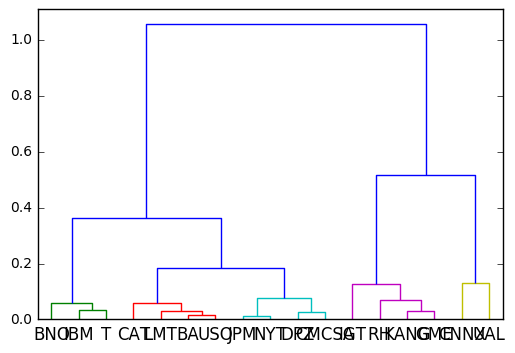

In [172]:
a,b,x = sp.stock_cluster(13)
_ = scipy.cluster.hierarchy.dendrogram(b,color_threshold=x,labels = scodes)
x

<h3>Training Days Analysis

In [173]:
from multiprocessing import Process,Manager,Pool



In [ ]:
pt_ind = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
pt_clu = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])

m = Manager()
ind = m.dict()
clu = m.dict()
pool = Pool(12)


def work(i):
    dunit_ind = build_decision_unit(sp,i)
    dunit_clu = build_decision_unit_by_cluster(sp,13,i)
    ind[i] = dunit_ind.accuracy_report().mean()
    clu[i] = dunit_clu.accuracy_report().mean()
    print(i,end = ' ')
    
pool.map(work,range(3,15))
pool.close()
pool.join()

# for i in range(3,15):
#     dunit_ind = build_decision_unit(sp,i)
#     dunit_clu = build_decision_unit_by_cluster(sp,13,i)
#     pt_ind = pt_ind.append([dunit_ind.accuracy_report().mean()] )
#     pt_clu = pt_clu.append([dunit_clu.accuracy_report().mean()] )
#     print(i,end = ' ')

In [ ]:
dict(clu)

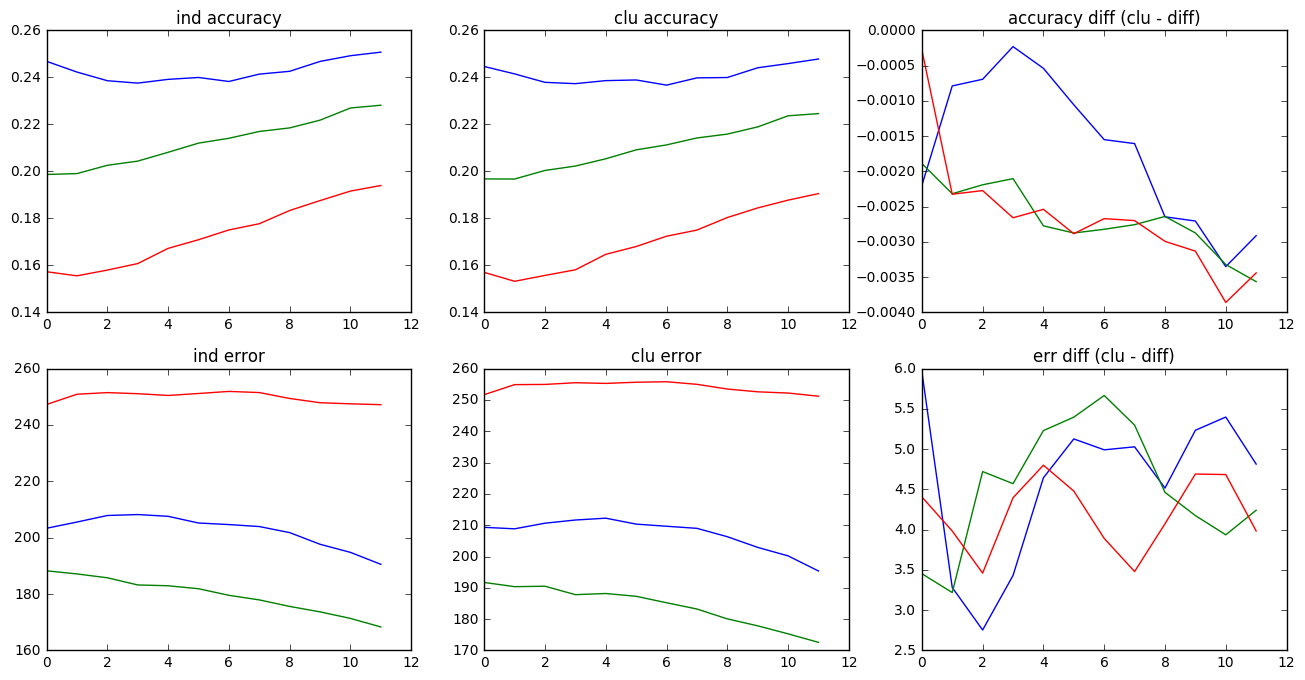

In [106]:
pt_ind = pt_ind.reset_index(drop=True)
pt_clu = pt_clu.reset_index(drop=True)

plt.figure(figsize=(16, 8))


plt.subplot(2, 3, 1)
plt.title('ind accuracy')
plt.plot(pt_ind[['h_acc','l_acc','c_acc']])

plt.subplot(2, 3, 2)
plt.title('clu accuracy')
plt.plot(pt_clu[['h_acc','l_acc','c_acc']])

plt.subplot(2, 3, 3)
plt.title('accuracy diff (clu - diff)')
plt.plot(pt_clu[['h_acc','l_acc','c_acc']]-pt_ind[['h_acc','l_acc','c_acc']])

plt.subplot(2, 3, 4)
plt.title('ind error')
plt.plot(pt_ind[['h_err','l_err','c_err']])

plt.subplot(2, 3, 5)
plt.title('clu error')
plt.plot(pt_clu[['h_err','l_err','c_err']])

plt.subplot(2, 3, 6)
plt.title('err diff (clu - diff)')
plt.plot(pt_clu[['h_err','l_err','c_err']]-pt_ind[['h_err','l_err','c_err']])

<h3>SMA Analysis

In [71]:
pt_ind_sma = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
pt_clu_sma = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
for i in range(3,20):
    sp.indexes = ['sma'+str(i*3)]
    sp.reset_index()
    dunit_ind = build_decision_unit(sp,5)
    dunit_clu = build_decision_unit_by_cluster(sp,13,5)
    pt_ind_sma = pt_ind_sma.append([dunit_ind.accuracy_report().mean()] )
    pt_clu_sma = pt_clu_sma.append([dunit_clu.accuracy_report().mean()] )
    print(i,end = ' ')

AttributeError: 'Stock_Pool' object has no attribute 'reset_index'

<h3>VAM Analysis

In [ ]:
pt_ind_vma = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
pt_clu_vma = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
for i in range(3,20):
    sp.indexes = ['vma'+str(i*3)]
    sp.reset_index()
    dunit_ind = build_decision_unit(sp,5)
    dunit_clu = build_decision_unit_by_cluster(sp,13,5)
    pt_ind_vma = pt_ind_vma.append([dunit_ind.accuracy_report().mean()] )
    pt_clu_vma = pt_clu_vma.append([dunit_clu.accuracy_report().mean()] )
    print(i,end = ' ')

<h3> William Indicator Analysis

In [ ]:
pt_ind_wr = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
pt_clu_wr = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
for i in range(3,20):
    sp.indexes = ['wr'+str(i*3)]
    sp.reset_index()
    dunit_ind = build_decision_unit(sp,5)
    dunit_clu = build_decision_unit_by_cluster(sp,13,5)
    pt_ind_wr = pt_ind_wr.append([dunit_ind.accuracy_report().mean()] )
    pt_clu_wr = pt_clu_wr.append([dunit_clu.accuracy_report().mean()] )
    print(i,end = ' ')

<h3>Boll Band Analysis

In [ ]:
pt_ind_boll = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
pt_clu_boll = pd.DataFrame([],columns = ['h_acc','l_acc','c_acc','h_err','l_err','c_err'])
for i in range(3,20):
    sp.indexes = ['boll'+str(i*3)]
    sp.reset_index()
    dunit_ind = build_decision_unit(sp,5)
    dunit_clu = build_decision_unit_by_cluster(sp,13,5)
    pt_ind_boll = pt_ind_boll.append([dunit_ind.accuracy_report().mean()] )
    pt_clu_boll = pt_clu_boll.append([dunit_clu.accuracy_report().mean()] )
    print(i,end = ' ')